## 1.随机采样

所谓采样，实际上是指根据某种分布去生成一些数据点。也就是说，这是我们根据观察数据再确定分布的过程的逆过程。

最基本的假设是认为我们可以获得均匀分布的随机数。一般的采样问题，都可以理解成，有了均匀分布的采样，如何去获取复杂分布的采样

对于连续的分布，如果可以计算这个分布的累积分布函数（CDF），就可以通过计算CDF的反函数，结合基础的均匀分布，获得其采样。所以，在这个基础上我们又可以获得一些简单的分布的采样。
Box-Muller算法，实现对高斯分布的采样。

![](https://raw.githubusercontent.com/applenob/machine_learning_basic/master/res/box_muller.png)

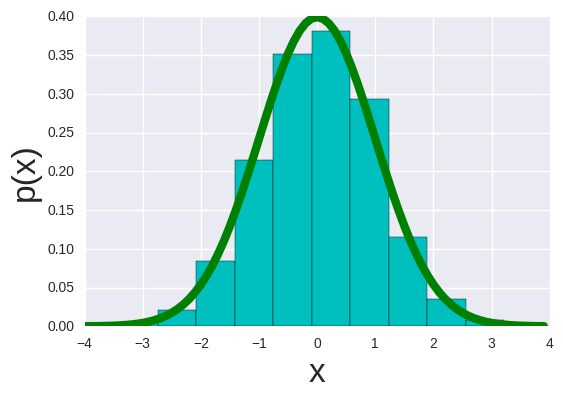

In [52]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# by Stephen Marsland (http://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008

# The Box-Muller algorithm for constructing pseudo-random Gaussian-distributed numbers

from pylab import *
from numpy import *

def boxmuller(n):
    
    x = zeros((n,2))
    y = zeros((n,2))
    
    for i in range(n):
        x[i,:] = array([2,2])
        x2 = x[i,0]*x[i,0]+x[i,1]*x[i,1]
        while (x2)>1:
            x[i,:] = random.rand(2)*2-1
            x2 = x[i,0]*x[i,0]+x[i,1]*x[i,1]

        y[i,:] = x[i,:] * sqrt((-2*log(x2))/x2)
    
    y = reshape(y,2*n,1)
    return y

y = boxmuller(1000)
hist(y,normed=1,fc='c')
x = arange(-4,4,0.1)
plot(x,1/sqrt(2*pi)*exp(-0.5*x**2),'g',lw=6)
xlabel('x',fontsize=24)
ylabel('p(x)',fontsize=24)
show()

Box-Muller的解法比较trick，还是通过转变随机变量，构造出目标分布。但是作为基础的分布采样，trick但是效率高，才是最重要。

接下来，我们专注于复杂的任意分布的采样。

## 2.拒绝采样（Rejection Sampling）

假设我们已经可以抽样高斯分布q(x)（如Box–Muller_transform 算法），我们按照一定的方法**拒绝**某些样本，达到接近p(x)分布的目的:
![reject](http://images.cnitblog.com/blog/533521/201310/25225434-fd6db018b45d4152a09ea1de2b5304ad.png)
具体操作：
- 首先，确定常量k，使得p(x)总在kq(x)的下方。
- x轴方向：从q(x)分布抽样得到a。但是a并不一定留下，会有一定的几率被**拒绝**
- y轴方向：从均匀分布(0,kq(a))中抽样得到u。如果u>p(a)，也就是落到了灰色的区域中，拒绝，否则接受这次抽样

拒绝采样实现：

reject count:  18207
Time  0.0656971931458


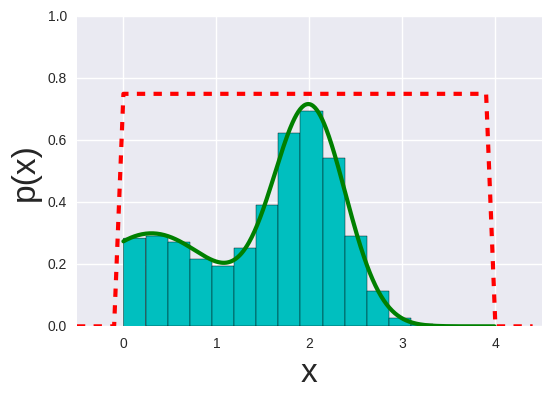

In [4]:
# -*- coding=utf8 -*-

# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# The basic rejection sampling algorithm
# 稍有修改，使用matplotlib

%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn

def qsample():
    """使用均匀分布作为q(x)，返回采样"""
    return np.random.rand()*4.

def p(x):
    """目标分布"""
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 

def rejection(nsamples):
    
    M = 0.72#0.8 k值
    samples = np.zeros(nsamples,dtype=float)
    count = 0
    for i in range(nsamples):
        accept = False
        while not accept:
            x = qsample()
            u = np.random.rand()*M
            if u<p(x):
                accept = True
                samples[i] = x
            else: 
                count += 1
    print "reject count: ", count   
    return samples

x = np.arange(0,4,0.01)
x2 = np.arange(-0.5,4.5,0.1)
realdata = 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 
box = np.ones(len(x2))*0.75#0.8
box[:5] = 0
box[-5:] = 0
plt.plot(x,realdata,'g',lw=3)
plt.plot(x2,box,'r--',lw=3)

import time
t0=time.time()
samples = rejection(10000)
t1=time.time()
print "Time ",t1-t0

plt.hist(samples,15,normed=1,fc='c')
plt.xlabel('x',fontsize=24)
plt.ylabel('p(x)',fontsize=24)
plt.axis([-0.5,4.5,0,1])
plt.show()

在高维的情况下，Rejection Sampling有两个问题：

1. 合适的q分布很难找
2. 很难确定一个合理的k值

导致拒绝率很高。

## 3. MCMC（Markov Chain Monte Carlo）
Markov Chain：
某一状态向量u(x)，有一个状态转移矩阵T，下一时刻的状态向量为u(x)T。
一直转换下去，系统趋近于稳态。

马尔科夫链若收敛，T需要满足
- 连通性（irreducibility）
- 没有死循环（aperiodicity）
- 细致平稳条件（detail balance）
![](http://images.cnitblog.com/blog/533521/201310/25225551-2a2b0e6e229741fa8daa660705cea9b5.png)

关键：
构造转移矩阵，使得平稳分布恰好是我们需要的分布p(x)

### 3.1 Metropolis-Hastings Algorithm
![](http://images.cnitblog.com/blog/533521/201310/25225600-1a8e76b63b3d4297a433b6f245cb6754.png)


上式中A是接受比率，推算过程：
由平稳细致条件得：
![](http://wenku.baidu.com/content/d0b441a8ccbff121dd36839a?m=5ad413ec5e0b7ba52336fe277bb442a7&type=pic&src=72a2fd5687c117390d81382ef4baee71.png)
根据p和q的关系：

$$p(x^{(i)}\rightarrow x^*)=q(x^{(i)}\rightarrow x^*)A(x^{(i)}\rightarrow x^*)$$

这里的A还是接受概率，参考reject sampling。
代入上式，整理可得：

$$\frac{A(x^{(i)}\rightarrow x^*)}{A(x^*\rightarrow x^{(i)})} = \frac{p(x^*)}{p(x^{(i)})}\cdot\frac{g(x^{(i)}\rightarrow x^*)}{g(x^*\rightarrow x^{(i)})}$$

上式可以理解为：“从状态x到x’的接受概率”与“x’到x的接受概率”的比率（接受率），这里的接受率再记为A。(因为x’到x是接受的逆过程，因此需要做除法)

MH算法实现：

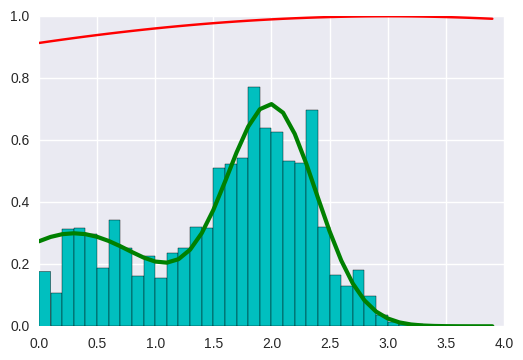

In [54]:
# my own try 
import scipy.stats
mu = 3
sigma = 10
def qsample():
    return np.random.normal(mu,sigma)
def q(x):
    return exp(-(x-mu)**2/(sigma**2))
def p(x):
    """目标分布"""
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3)
def hm(n=10000):
    sample = np.zeros(n)
    sample[0] = 0.5
    for i in range(n-1):
        q_s = qsample()
        u = np.random.rand()
        if u < min(1, (p(q_s)*q(sample[i]))/(p(sample[i])*q(q_s))):
            sample[i+1] = q_s
        else:
            sample[i+1] = sample[i]
    return sample

x = np.arange(0,4,0.1)
realdata = p(x)
N=10000
sample = hm(N)
plt.plot(x,realdata,'g',lw=3)
plt.plot(x,q(x),'r')
plt.hist(sample,bins=x,normed=1,fc='c')
plt.show()

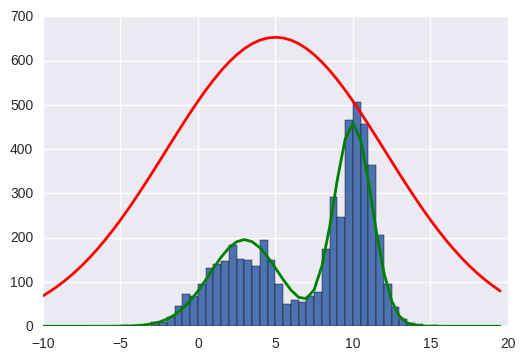

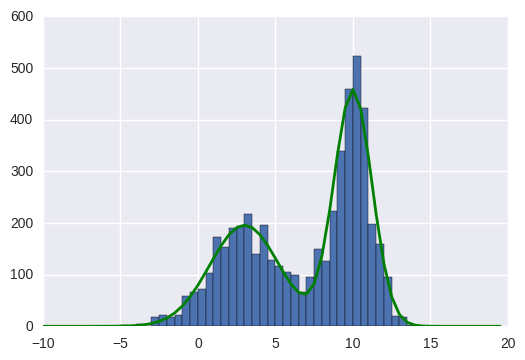

In [31]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# by Stephen Marsland (http://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008

# The Metropolis-Hastings algorithm
from pylab import *
from numpy import *

def p(x):
    mu1 = 3
    mu2 = 10
    v1 = 10
    v2 = 3
    return 0.3*exp(-(x-mu1)**2/v1) + 0.7* exp(-(x-mu2)**2/v2)

def q(x):
    mu = 5
    sigma = 10
    return exp(-(x-mu)**2/(sigma**2))

stepsize = 0.5
x = arange(-10,20,stepsize)
px = zeros(shape(x))
for i in range(len(x)):
    px[i] = p(x[i])
N = 5000

# independence chain
u = random.rand(N)
mu = 5
sigma = 10
y = zeros(N)
y[0] = random.normal(mu,sigma)
for i in range(N-1):
    ynew = random.normal(mu,sigma)
    alpha = min(1,p(ynew)*q(y[i])/(p(y[i])*q(ynew)))
    if u[i] < alpha:
        y[i+1] = ynew
    else:
        y[i+1] = y[i]

# random walk chain
u2 = random.rand(N)
sigma = 10
y2 = zeros(N)
y2[0] = random.normal(0,sigma)
for i in range(N-1):
    y2new = y2[i] + random.normal(0,sigma)
    alpha = min(1,p(y2new)/p(y2[i]))
    if u2[i] < alpha:
        y2[i+1] = y2new
    else:
        y2[i+1] = y2[i]

figure(1)
nbins = 30
hist(y, bins = x)
plot(x, px*N/sum(px), color='g', linewidth=2)
plot(x, q(x)*N/sum(px), color='r', linewidth=2)

figure(2)
nbins = 30
hist(y2, bins = x)
plot(x, px*N/sum(px), color='g', linewidth=2)

show()

### 3.2 Gibbs Sampling

Gibbs Sampling是重点，它的本质是MH的变种。对于高维的使用场景，由于接受率A的存在（通常A < 1），使得MH效率不高，于是希望找到转移矩阵，使得**接受率A=1**。

如果采用设置多维概率分布P里的**完全条件概率(full conditionals)**作为**建议概率(proposal)**，那么接受率就会始终=1，一直接受x’。

**完全条件概率(full conditionals)**:
![](http://wenku.baidu.com/content/d0b441a8ccbff121dd36839a?m=5ad413ec5e0b7ba52336fe277bb442a7&type=pic&src=e5e87087c7230e8ce372dda00612e13c.png)

证明：
![](http://wenku.baidu.com/content/d0b441a8ccbff121dd36839a?m=5ad413ec5e0b7ba52336fe277bb442a7&type=pic&src=f91591157a4e237cc0cea8e2a959022c.png)

**Gibbs Sampling**

![](http://images.cnitblog.com/blog/533521/201310/25225719-116e5550e9fd448f894cddc6b6ab02b4.png)

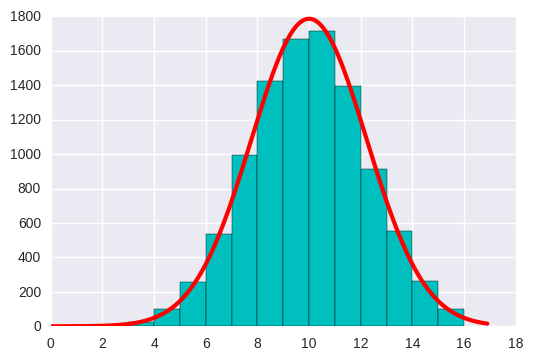

In [6]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# A simple Gibbs sampler

def pXgivenY(y,m1,m2,s1,s2):
    return np.random.normal(m1 + (y-m2)/s2,s1)

def pYgivenX(x,m1,m2,s1,s2):
    return np.random.normal(m2 + (x-m1)/s1,s2)

def gibbs(N=5000):
    k=20
    x0 = np.zeros(N,dtype=float)
    m1 = 10
    m2 = 20
    s1 = 2
    s2 = 3
    for i in range(N):
        y = np.random.rand(1)
        # 每次采样需要迭代 k 次
        for j in range(k):
            x = pXgivenY(y,m1,m2,s1,s2)
            y = pYgivenX(x,m1,m2,s1,s2)
        x0[i] = x
    
    return x0

def f(x):
    """目标分布"""
    return np.exp(-(x-10)**2/10)

# 画图
N=10000
s=gibbs(N)
x1 = np.arange(0,17,1)
plt.hist(s,bins=x1,fc='c')
x1 = np.ar
ange(0,17, 0.1)
px1 = np.zeros(len(x1))
for i in range(len(x1)):
    px1[i] = f(x1[i])
plt.plot(x1, px1*N*10/sum(px1), color='r',linewidth=3)

plt.show()

以上算法是简单的二维Gibbs Sampling的实现，如下图：
![](https://raw.githubusercontent.com/applenob/machine_learning_basic/master/res/gibbs2.png)

懂了Gibbs Sampling， LDA就不远了，接下来会去研究LDA的实现。

参考资料：

- [LDA漫游指南](http://yuedu.baidu.com/ebook/d0b441a8ccbff121dd36839a)
- [从随机过程到马尔科夫链蒙特卡洛方法](http://www.cnblogs.com/daniel-D/p/3388724.html)
- [Machine learning an algorithmic perspective](https://www.amazon.de/Machine-Learning-Algorithmic-Perspective-Recognition/dp/1420067184)
- [LDA-math-MCMC 和 Gibbs Sampling](http://cos.name/2013/01/lda-math-mcmc-and-gibbs-sampling/)